# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [39]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp
import importlib

In [2]:
sys.path.append('..')

In [3]:
import pulse_sequences as ps

In [84]:
# importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

## Define system

In [4]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 25

In [5]:
X, Y, Z = ps.get_collective_spin(N)

In [6]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength) for _ in range(ensemble_size)]
pulses_ensemble = [
    ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble
]

In [7]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Define and evaluate pulse sequences



In [8]:
f = ps.get_mean_fidelity(ps.cory48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999998436839438, 6.805996410558396)

In [9]:
f = ps.get_mean_fidelity(ps.yxx24 * 2, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999989945678126, 5.997647215602443)

In [10]:
f = ps.get_mean_fidelity(ps.yxx48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999993244050204, 6.17031358634872)

In [11]:
f = ps.get_mean_fidelity(ps.az3, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9985795795086375, 2.847583071077926)

In [12]:
f = ps.get_mean_fidelity(ps.az48, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999511833211632, 4.311431770430972)

In [13]:
f = ps.get_mean_fidelity(ps.az48_1, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.9999509821656865, 4.309645880486085)

In [16]:
f = ps.get_mean_fidelity(ps.az48_2, Utarget, pulses_ensemble)
f, -np.log10(1 - f)

(0.999925082185048, 4.125414897716322)

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

### Rotation errors

In [17]:
rot_errors = np.linspace(-1, 1, 15)
rot_errors = .05 * rot_errors**2 * np.sign(rot_errors) # non-linear sampling

In [18]:
def f(pulse_sequence, rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(pulse_sequence, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [19]:
def get_rot_data(pulse_sequence, rot_errors, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(f, [(pulse_sequence, r) for r in rot_errors])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [20]:
cory48_output = get_rot_data(ps.cory48, rot_errors)

In [21]:
yxx48_output = get_rot_data(ps.yxx48, rot_errors)

In [192]:
# yxx24_output = get_rot_data(ps.yxx24 * 2, rot_errors)

In [193]:
# az3_output = get_rot_data(ps.az3, rot_errors)

In [194]:
# az12_output = get_rot_data(ps.az12 * 4, rot_errors)

In [22]:
az48_output = get_rot_data(ps.az48, rot_errors)

In [24]:
az48_1_output = get_rot_data(ps.az48_1, rot_errors)

In [25]:
az48_2_output = get_rot_data(ps.az48_2, rot_errors)

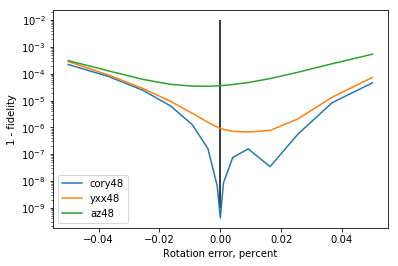

In [29]:
plt.plot(rot_errors, 1-cory48_output[0], label='cory48')
plt.plot(rot_errors, 1-yxx48_output[0], label='yxx48')
plt.plot(rot_errors, 1-az48_output[0], label='az48')
# plt.plot(rot_errors, 1-az48_1_output[0], label='az48_1')
# plt.plot(rot_errors, 1-az48_2_output[0], label='az48_2')
plt.vlines(0, 10**-9, 10**-2, 'k')
plt.xlabel('Rotation error, percent')
plt.ylabel('1 - fidelity')
plt.yscale('log')
plt.legend()
plt.savefig('rot_error.png')

In [43]:
# plt.errorbar(rot_errors, 1-cory48_output[0], yerr=cory48_output[1], label='cory48')
# plt.errorbar(rot_errors, 1-yxx48_output[0], yerr=yxx48_output[1], label='yxx48')
# # plt.errorbar(rot_errors, 1-yxx24_output[0], yerr=yxx24_output[1], label='yxx24')
# # plt.errorbar(rot_errors, 1-az3_output[0], yerr=az3_output[1], label='az3')
# # plt.errorbar(rot_errors, 1-az12_output[0], yerr=az12_output[1], label='az12')
# plt.errorbar(rot_errors, 1-az48_output[0], yerr=az48_output[1], label='az48')
# plt.errorbar(rot_errors, 1-az48_1_output[0], yerr=az48_1_output[1], label='az48_1')
# plt.xlabel('Rotation error, percent')
# plt.ylabel('1 - fidelity')
# plt.yscale('log')
# plt.legend()

### Phase transients

In [30]:
phase_transients = 1e-2 * np.linspace(0, 1, 15)**2

In [31]:
def g(pulse_sequence, pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    fidelities = [ps.get_fidelity(pulse_sequence, Utarget, p) for p in pe]
    return np.mean(fidelities), np.std(fidelities)

In [32]:
def get_pt_data(pulse_sequence, phase_transients, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(g, [(pulse_sequence, r) for r in phase_transients])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [33]:
cory48_pt_output = get_pt_data(ps.cory48, phase_transients)

In [34]:
yxx48_pt_output = get_pt_data(ps.yxx48, phase_transients)

In [205]:
# yxx24_pt_output = get_pt_data(ps.yxx24 * 2, phase_transients)

In [149]:
# az3_pt_output = get_pt_data(ps.az3, phase_transients)

In [150]:
# az12_pt_output = get_pt_data(ps.az12 * 4, phase_transients)

In [35]:
az48_pt_output = get_pt_data(ps.az48, phase_transients)

In [81]:
az48_1_pt_output = get_pt_data(ps.az48_1, phase_transients)

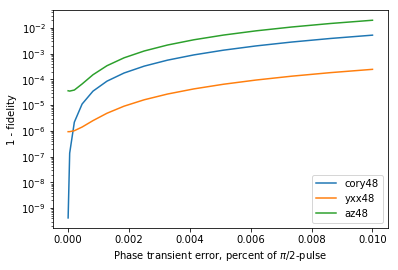

In [37]:
plt.plot(phase_transients, 1-cory48_pt_output[0], label='cory48')
plt.plot(phase_transients, 1-yxx48_pt_output[0], label='yxx48')
plt.plot(phase_transients, 1-az48_pt_output[0], label='az48')
# plt.plot(phase_transients, 1-az48_1_pt_output[0], label='az48_1')
plt.yscale('log')
plt.xlabel(r'Phase transient error, percent of $\pi/2$-pulse')
plt.ylabel('1 - fidelity')
plt.legend()
plt.savefig('phase_transient_error.png')

In [82]:
# plt.errorbar(phase_transients, 1-cory48_pt_output[0], yerr=cory48_pt_output[1], label='cory48')
# plt.errorbar(phase_transients, 1-yxx48_pt_output[0], yerr=yxx48_pt_output[1], label='yxx48')
# # plt.errorbar(phase_transients, 1-yxx24_pt_output[0], yerr=yxx24_pt_output[1], label='yxx24')
# # plt.errorbar(phase_transients, 1-az3_pt_output[0], yerr=az3_pt_output[1], label='az3')
# plt.errorbar(phase_transients, 1-az48_pt_output[0], yerr=az48_pt_output[1], label='az48')
# plt.yscale('log')
# plt.xlabel(r'Phase transient error, percent of $\pi/2$-pulse')
# plt.ylabel('1 - fidelity')
# plt.legend()